In [97]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [2]:
np.random.seed(0)

In [3]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [4]:
df = df[~df['written']]

<Axes: >

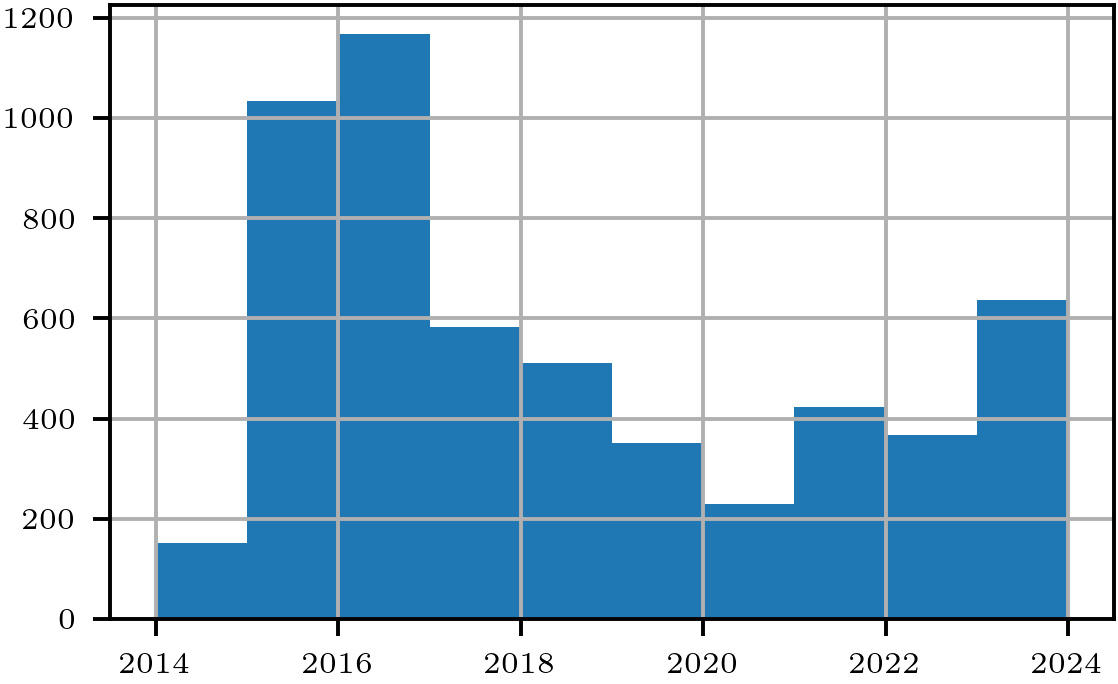

In [5]:
df['year'].hist()

In [6]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

In [7]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, test_size=.1)


lb = LabelEncoder()
y_train = lb.fit_transform(train["block"])
y_test = lb.transform(test["block"])

X_test = np.stack(test[EMBEDDING_MODEL])
X_train = np.stack(train[EMBEDDING_MODEL])
print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X_train, y)

reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))

print(f"PLS r-squared {pls.score(X_test, np.eye(len(lb.classes_))[y_test]):.3f}")


#Classes 6
PLS r-squared 0.106


In [9]:
df['reduced_0'] = reduced[:, 0] 
df['reduced_1'] = reduced[:, 1] 

In [10]:
for year in test['year'].unique():
    mask = year == test['year'] 
    X_year = np.stack(test[mask][EMBEDDING_MODEL])
    y_year = lb.transform(test[mask]['block'])
    y_pred =  pls.predict(X_year).argmax(axis=1)
    print(year, len(y_year))
    print(f"PLS Accuracy {(y_pred == y_year).mean()}")


2020 21
PLS Accuracy 0.42857142857142855
2023 55
PLS Accuracy 0.509090909090909
2015 101
PLS Accuracy 0.4158415841584158
2016 121
PLS Accuracy 0.33884297520661155
2018 42
PLS Accuracy 0.5
2021 42
PLS Accuracy 0.6428571428571429
2017 70
PLS Accuracy 0.5142857142857142
2022 37
PLS Accuracy 0.32432432432432434
2024 11
PLS Accuracy 0.6363636363636364
2019 30
PLS Accuracy 0.4
2014 16
PLS Accuracy 0.625


## Plotting Results

In [11]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict, ax):
  ax.set_title("Two Dimensional Projection of Political Groups")

  grt_y = np.abs(reduced_embeddings[:, 1]).max() * 1.1
  grt_x = np.abs(reduced_embeddings[:, 0]).max() * 1.1

  ax.set_xlim(-grt_x, grt_x)
  ax.set_ylim(-grt_y, grt_y)

  scale = grt_y * 2

  unique_years = list(aggregated['year'].unique() )
  years_to_display = unique_years[::-2]

  ax.set_xlabel("First Axis")
  ax.set_ylabel("Second Axis")

  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        if year in years_to_display:
          ax.text(party_embeddings[i,0] - scale * 0.025, party_embeddings[i,1]+ scale * 0.03, f"{year}",
                    fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                    color='white',
                    )

  ax.axhline(0, linestyle="--")
  ax.axvline(0, linestyle="--")
  ax.grid()
  ax.legend(loc="upper left")
  return ax

In [12]:
import seaborn as sns
def plot_pca_axis_development(df: pd.DataFrame, axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict, ax: plt.Axes,
                              top_k: int = 3):

    ax.set_title(f"Development of parties over the years accross reduced-axis {axis + 1}")


    sns.lineplot(data=df, x='year', y=f"reduced_{axis}", marker='o', hue=target_var, palette=color_map, ax=ax, legend=False)
    ax.set_ylabel("")

    
    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()
    # ax.legend(loc="lower left")


In [13]:
df['translatedText'].str.contains("border").sum() / len(df) * 100

np.float64(50.907757197872726)

In [14]:
df[df['translatedText'].str.contains("border")]['year'].value_counts()

year
2016    575
2015    472
2021    300
2023    280
2017    245
2018    239
2022    233
2019    174
2020    141
2014     63
2024     54
Name: count, dtype: int64

In [15]:
df[~df['translatedText'].str.contains("border")]['year'].value_counts()

year
2016    593
2015    562
2017    337
2018    272
2023    256
2019    178
2022    134
2021    123
2020     88
2014     88
2024     46
Name: count, dtype: int64

In [16]:
def display_results(df: pd.DataFrame, model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    
    fig = plt.figure(layout="constrained")

    gs0 = fig.add_gridspec(1, 2)

    gs1 = gs0[1].subgridspec(2, 1)

    ax1 = fig.add_subplot(gs0[0])
    ax2 = fig.add_subplot(gs1[0])
    ax3 = fig.add_subplot(gs1[1], sharex=ax2)

    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map, ax1)
    plot_pca_axis_development(df, 0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map, ax2)
    plot_pca_axis_development(df, 1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map, ax3)


In [17]:
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"


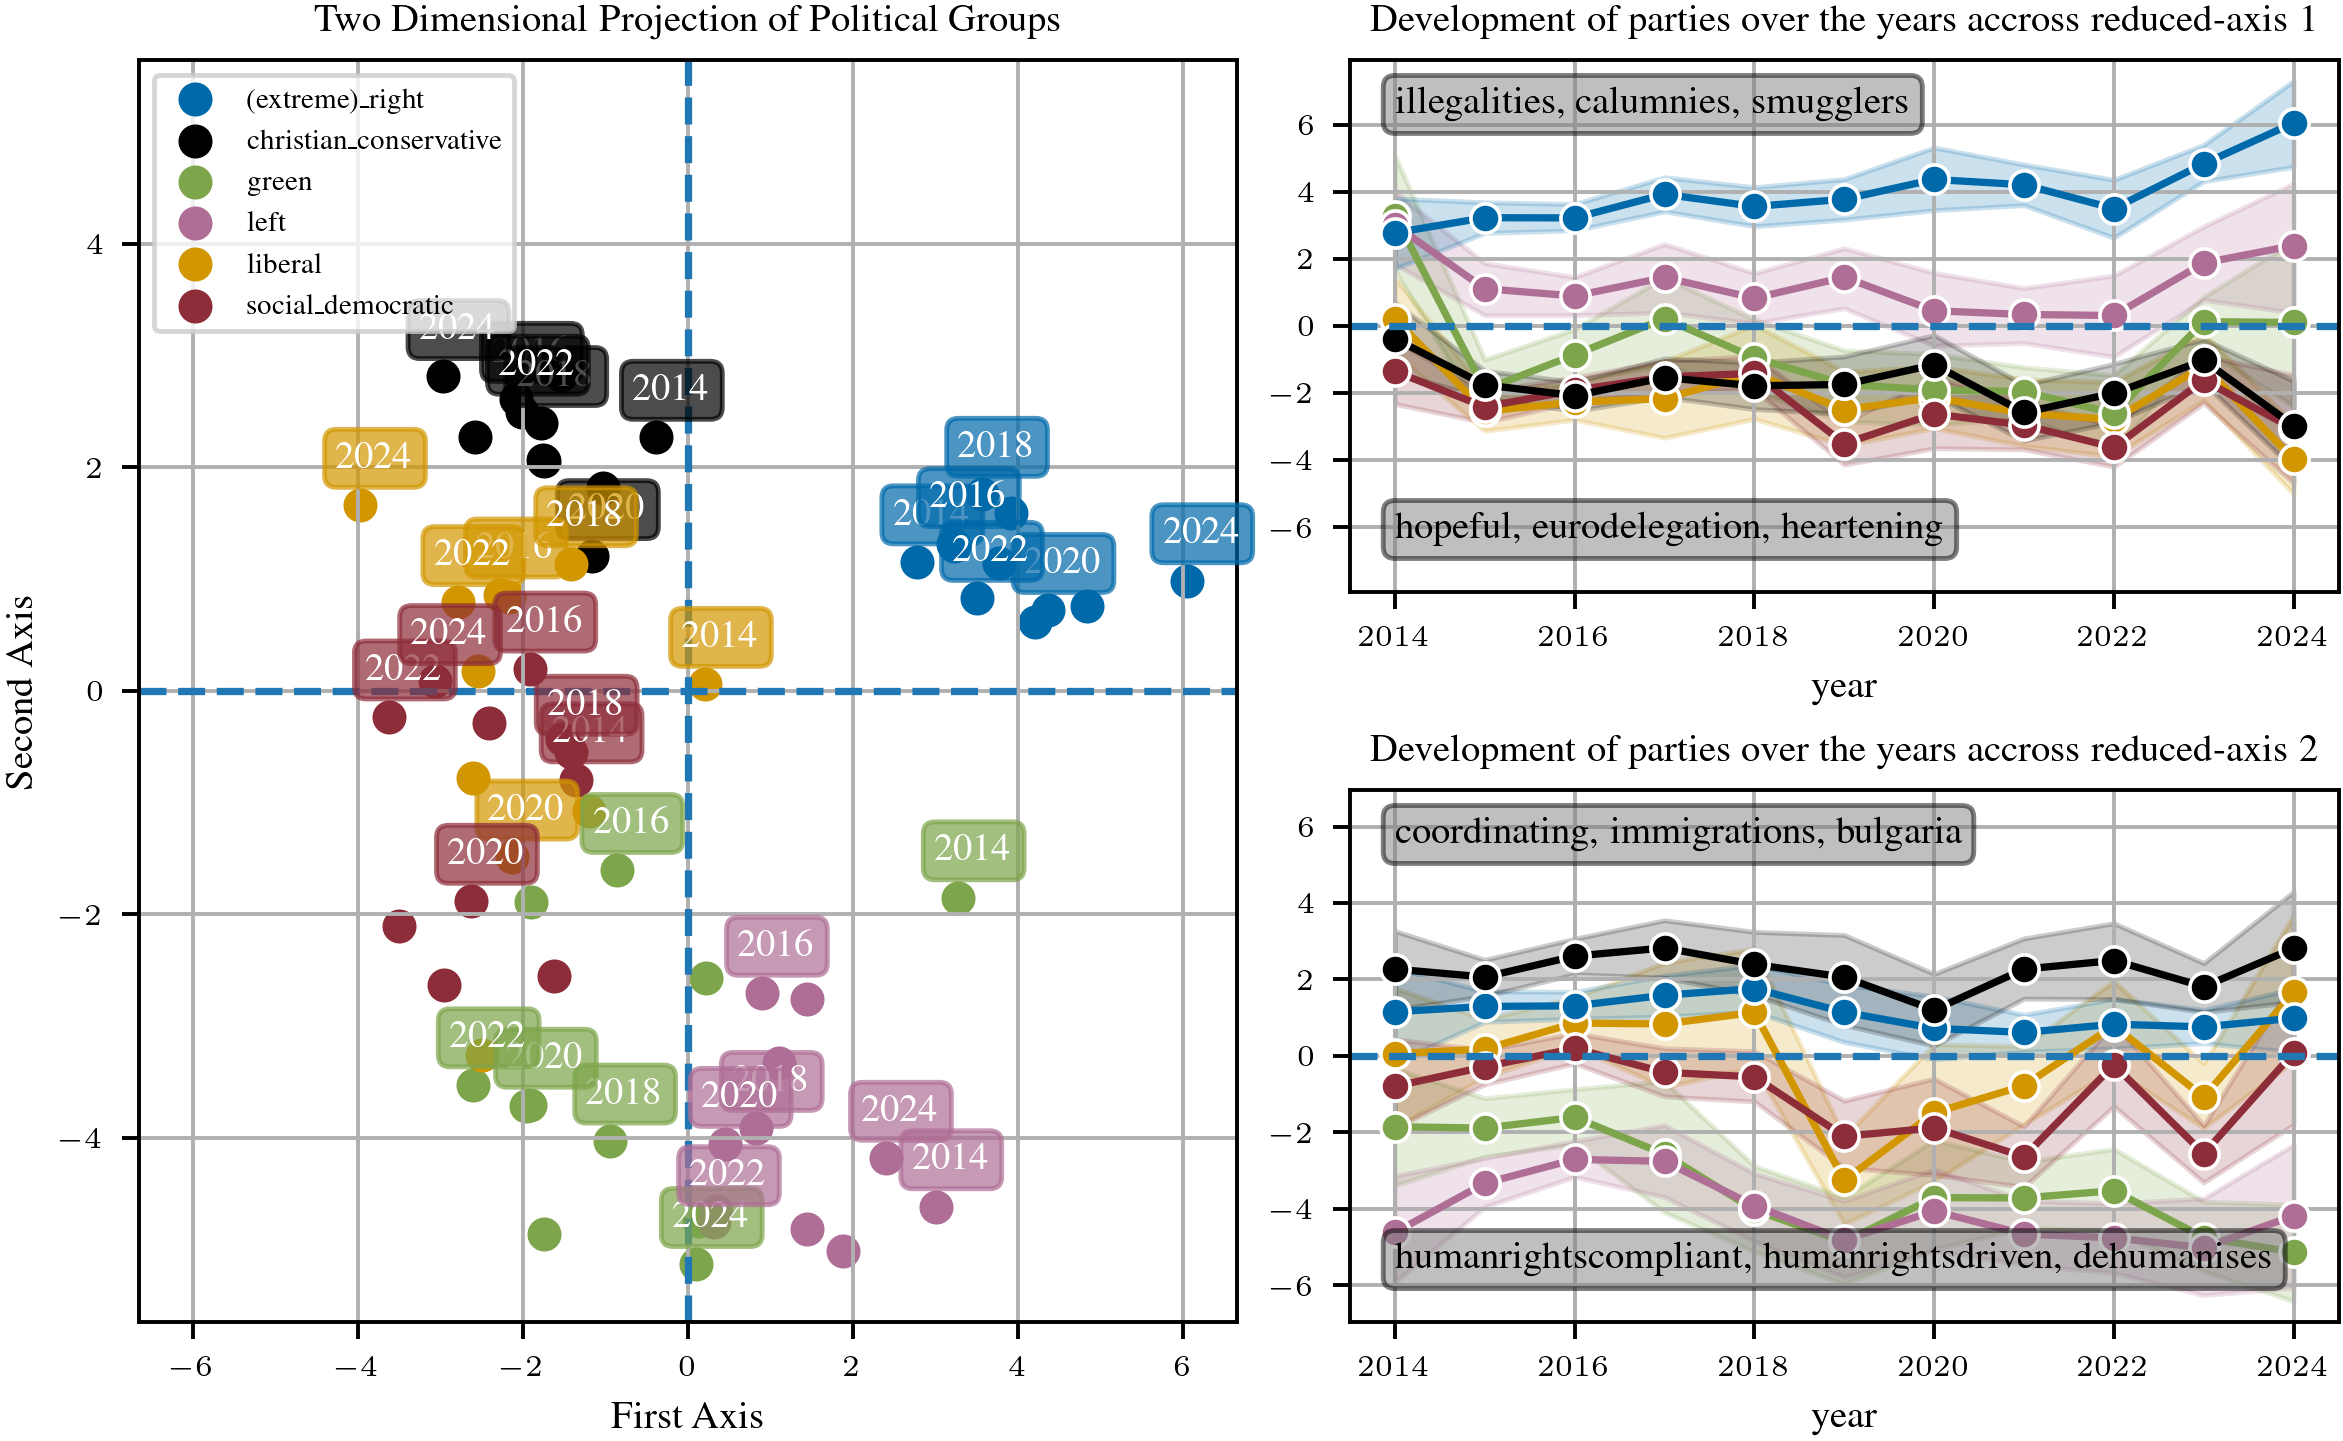

In [18]:
from tueplots import bundles

params = bundles.icml2024(nrows=1,ncols=1, column="full") # if you need multiple columns / rows, change in your script
# params.update({"figure.dpi": 350})
plt.rcParams.update(params)

display_results(df, pls, [0, 1], aggregated, vocab_df, 
                pls.transform(np.stack(aggregated[EMBEDDING_MODEL])), "block", COLOR_MAPS['block'])

In [19]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))
normalized = reduced 
#/ np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)

In [20]:
def get_top_k_extreme_examples(df: pd.DataFrame, embeddings: np.array, top_k=10):
    sorted_0 = embeddings[:, 0].argsort()
    sorted_1 = embeddings[:, 1].argsort()
    return df.iloc[sorted_0[:top_k]], df.iloc[sorted_0[-top_k:]], df.iloc[sorted_1[:top_k]], df.iloc[sorted_1[-top_k:]]

In [21]:
import textwrap


left_mask = df['block'] == '(extreme)_right'
neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[left_mask], normalized[left_mask])

In [22]:
for row in neg_1.iloc:
    print(textwrap.fill(row['translatedText']))
    print("=" * 200)

Madam President, this report discusses many aspects that I
wholeheartedly support: gender equality; access to education;
eradicating discrimination; and the prevention of violence against
women. But more importantly, what this report touches on – which I
definitely condemn – is the absolutely horrific human rights
violations which take place in Libyan detention centres. Women at the
hands of Libyan coastal guards are subjected to gang rapes, men are
beaten to death, there is no food, no basic amenities, and appalling
unimaginable living conditions. These are the same coastal guards that
the EU are training. One cannot begin to imagine the fear, terror and
despair of these victims. This is despite prior warnings from human
rights organisations that warned of the exacerbation of such crimes.
The UN human rights chief stated that the EU’s policy of assisting the
Libyan coast guard was inhumane and that increasing interventions by
the EU have done nothing to reduce the level of abuse suffe

In [23]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [24]:
axis_labels_0[1]

[('illegalities', np.float64(15.32392971026007)),
 ('calumnies', np.float64(15.327185012757651)),
 ('smugglers', np.float64(15.367439470981347)),
 ('mockery', np.float64(15.373689137398332)),
 ('fraudsters', np.float64(15.384503654291214)),
 ('hypocrites', np.float64(15.422542822258013)),
 ('malicious', np.float64(15.427546654904214)),
 ('traffickersexploiters', np.float64(15.489540719330304)),
 ('racists', np.float64(15.685866942667808)),
 ('antiimmigrant', np.float64(15.715295535700584)),
 ('fraudulent', np.float64(15.715556095097016)),
 ('illegal', np.float64(15.76551970322496)),
 ('illegitimately', np.float64(15.767031679550207)),
 ('thugs', np.float64(15.784849376738403)),
 ('идиоты', np.float64(15.98285108277685)),
 ('ridiculous', np.float64(16.043090195497488)),
 ('antimigrant', np.float64(16.952517724072045)),
 ('antiimmigrationist', np.float64(17.00048292513673)),
 ('antiimmigration', np.float64(17.12629502834532)),
 ('antiimmigrants', np.float64(17.50533178648644))]

In [25]:
words_neg_0, words_pos_0 = [[item[0] for item in axis_label] for axis_label in axis_labels_0]
words_neg_1, words_pos_1 = [[item[0] for item in axis_label] for axis_label in axis_labels_1]

In [26]:
examples = []

for block in df['block'].unique():
    block_mask = df['block'] == block
    neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[block_mask], normalized[block_mask], top_k=3)

    examples.extend([{"Axis": "First", 
    "Direction": "Positive (Right)",
    "Labels": ", ".join(words_pos_0),
    "Block": block,
    **{ f"Example: {idx}":  textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(pos_0.iloc)}},


    {"Axis": "First", 
    "Direction": "Negative (Left)",
    "Labels": ", ".join(words_neg_0),
    "Block": block,
    **{ f"Example: {idx}":textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(neg_0.iloc)}},


    {"Axis": "Second", 
    "Direction": "Positive (Up)",
    "Labels": ", ".join(words_pos_1),
    "Block": block,
    **{ f"Example: {idx}":  textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(pos_1.iloc)}},


    {"Axis": "Second", 
    "Direction": "Negative (Down)",
    "Labels": ", ".join(words_neg_1),
    "Block": block,
    **{ f"Example: {idx}": textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(neg_1.iloc)}}])



In [28]:
examples_df = pd.DataFrame(examples)

In [29]:
examples_df = examples_df.sort_values(by=['Axis', 'Direction', 'Labels', 'Block'])

In [30]:
examples_df = examples_df.set_index([ 'Axis', 'Direction', 'Labels', 'Block' ])


In [31]:
from IPython.display import display, HTML

display(HTML(examples_df.to_html()))

In [32]:
pos_1['block']

200415    christian_conservative
80518     christian_conservative
159812    christian_conservative
Name: block, dtype: object

In [33]:
X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()

# create one-hot encodding to use PLS for classification PLS-DA

y_block = lb.fit_transform(df["block"])
y_block = np.eye(len(lb.classes_))[y_block]
y_year = lb.fit_transform(df["year"])
y_year = np.eye(len(lb.classes_))[y_year] 

y = np.concat([y_block, y_year], axis=1)


pls = PLSRegression(n_components=2)
pls.fit(X, y)

reduced = pls.transform(X)

# PLS + Clustering
With PLS and our vocab embeddings we can try to find out which 

In [300]:
len(df['party'].unique())

8

First thing we want to do is find num of clusters who can separate our data the most. For this we can use silhouette coefficient
nearest_other_cluster_dist - intra_cluster_dist / max_of_the_two

In [301]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm


silhouette_scores = {}

for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

    kmeans = KMeans(n_clusters=num_clusters)
    predicted_clusters = kmeans.fit_predict(X)

    silhouette_scores[num_clusters] = silhouette_score(X, predicted_clusters)


100%|██████████| 81/81 [01:13<00:00,  1.11it/s]


In [302]:
max(silhouette_scores.items(), key=lambda item: item[1])

(27, 0.028258703649044037)

Near 0 meaning clusters are overlaping, not as easily separable as we'd have liked

In [303]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# X = np.stack(df[EMBEDDING_MODEL])
# results = {}

# for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

#     kmeans = KMeans(n_clusters=num_clusters)
#     predicted_clusters = kmeans.fit_predict(X)

#     pls = PLSRegression(n_components=2)

#     y = np.eye(num_clusters)[predicted_clusters]

#     X_train, X_test, y_train, y_test = train_test_split(X, y)

#     pls.fit(X_train, y_train)

#     y_pred = pls.predict(X_test).argmax(axis=1)
#     y_test = y_test.argmax(axis=1)

    
#     results[num_clusters] = f1_score(y_test, y_pred, average="micro")  # classes are getting bigger as n_clusters increases so we want to make it n_class agnostic by measuring micro labels

In [304]:
kmeans = KMeans(n_clusters=72)
predicted_clusters = kmeans.fit_predict(X)

In [305]:
df.groupby(predicted_clusters)['block'].value_counts()

    block                 
0   christian_conservative    30
    (extreme)_right           15
    left                       4
    green                      2
    social_democratic          1
                              ..
71  social_democratic         12
    christian_conservative    10
    liberal                    8
    green                      3
    left                       1
Name: count, Length: 414, dtype: int64

In [306]:
pls = PLSRegression(n_components=2)
y = np.eye(num_clusters)[predicted_clusters]
pls.fit(X, y)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


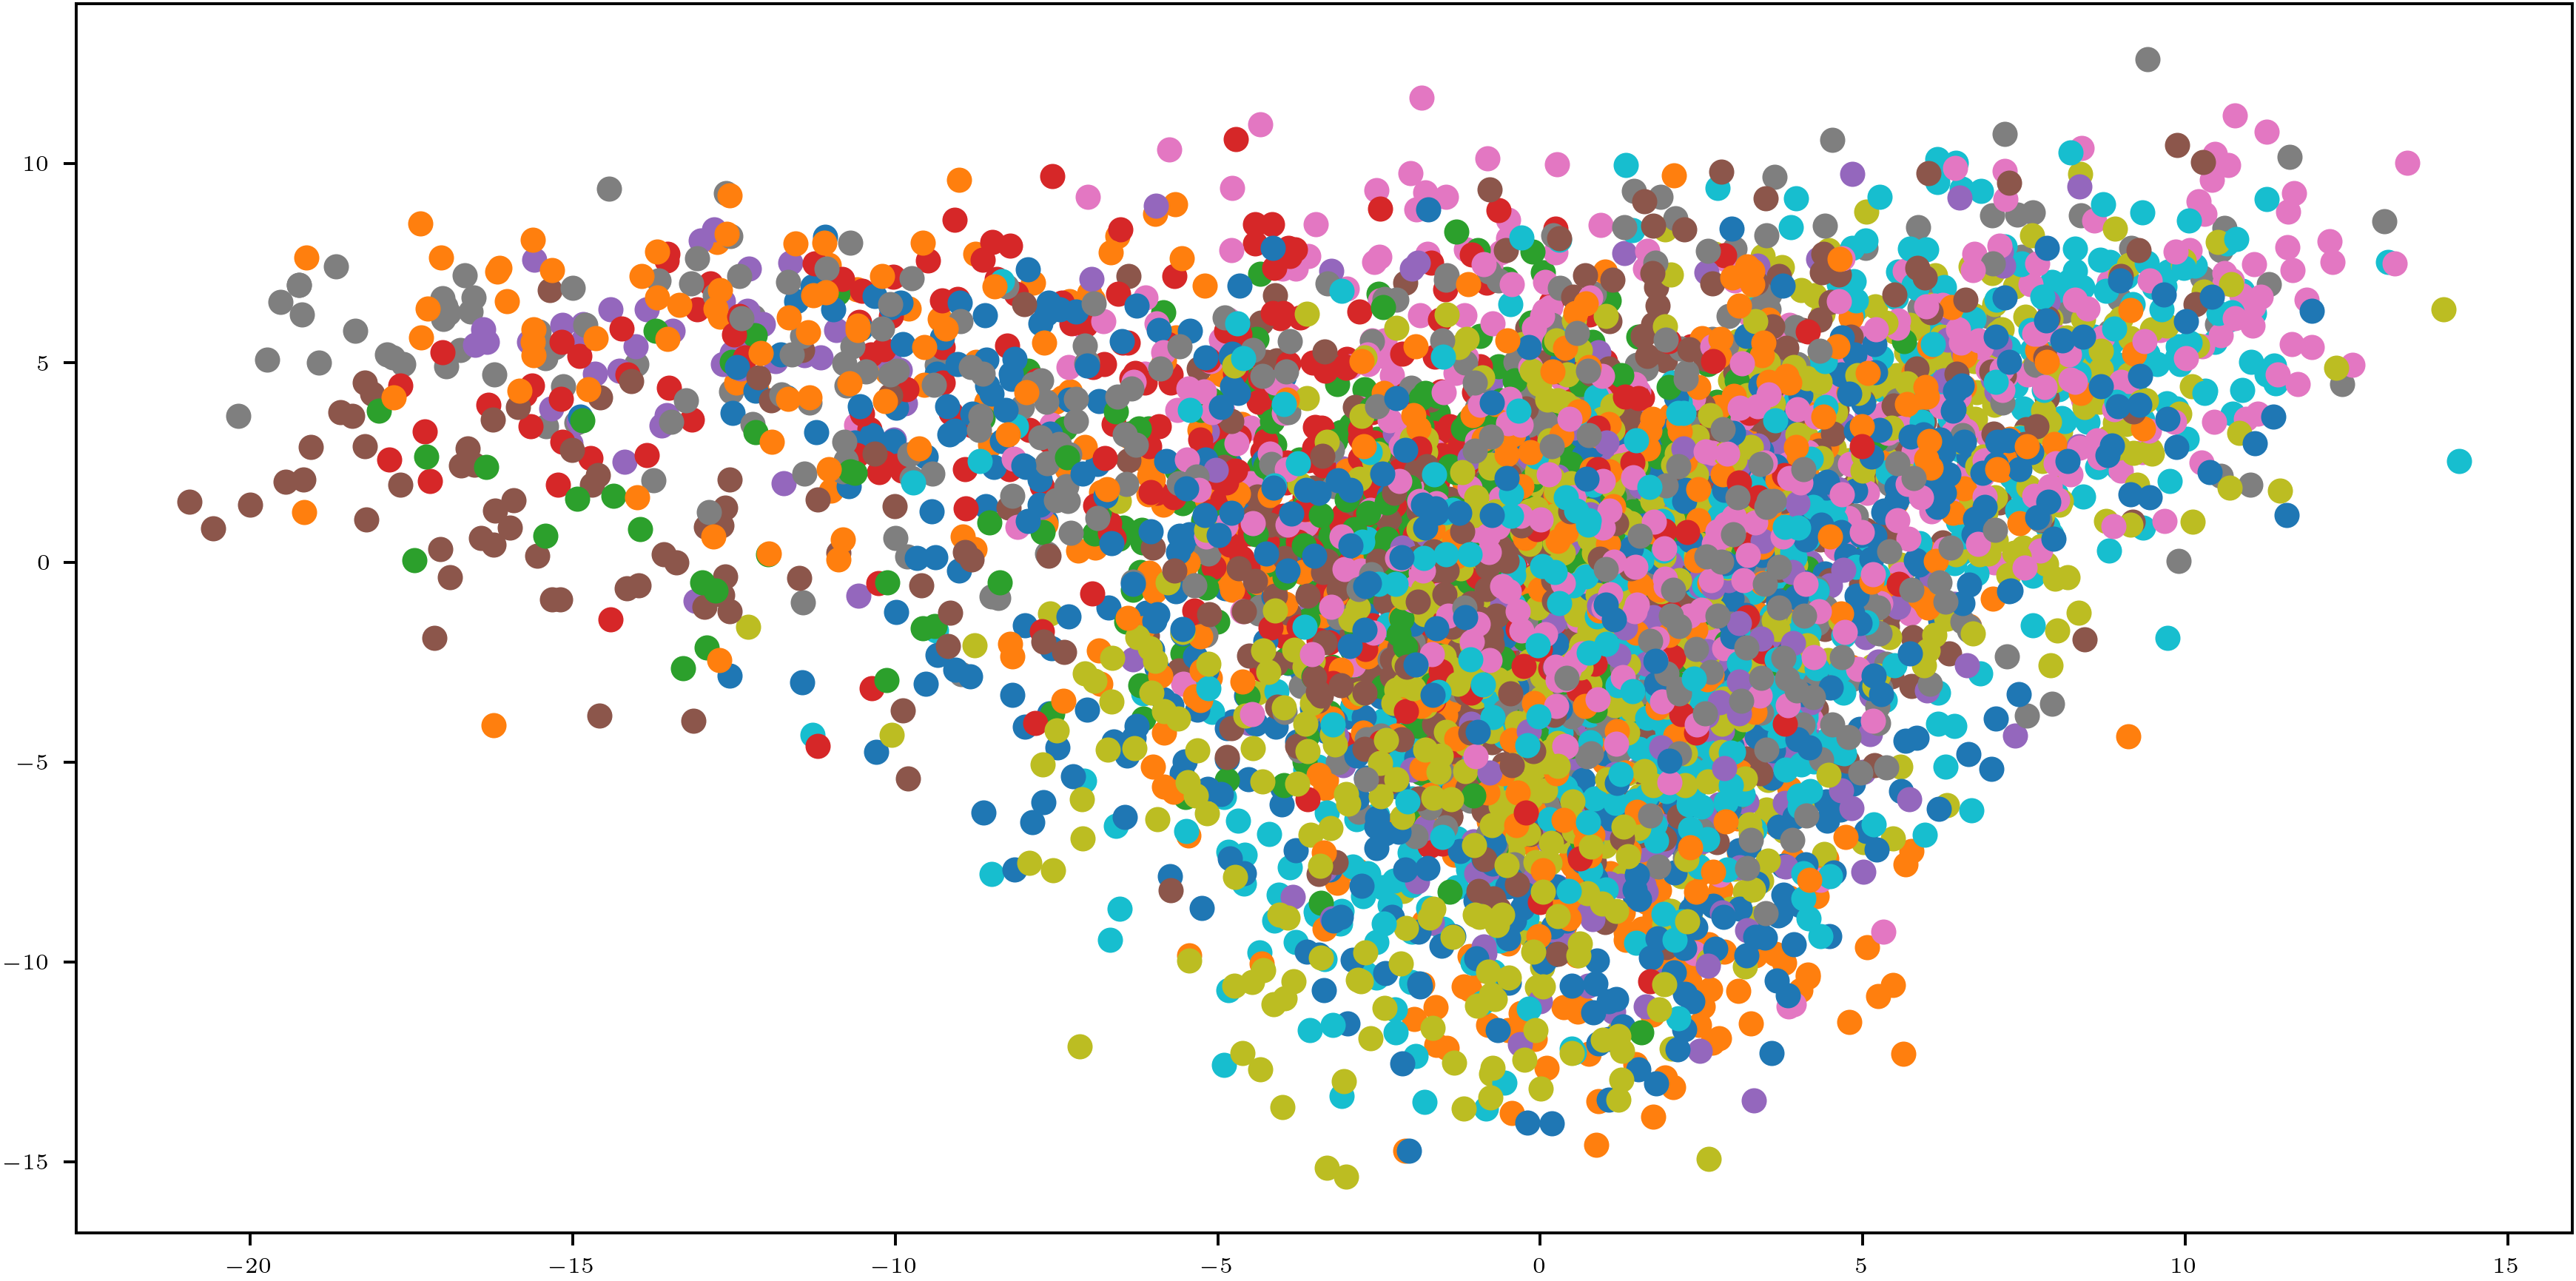

In [307]:
reduced = pls.transform(X)

fig, ax = plt.subplots(figsize=(10, 5))

for cluster_id in range(72):
    mask = predicted_clusters == cluster_id
    ax.scatter(reduced[mask, 0], reduced[mask, 1])

In [308]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [309]:
display_axis_semantics([axis_labels_0, axis_labels_1])

# CHES score 

In [50]:
from src.constants import PATH_MIGRATION_CHES
ches_df = pd.read_parquet("data/final/migration_with_CHES_exact.parquet")

In [57]:
ches_df.columns[24:]

Index(['party_label_ep', 'party_all_labels_ep', 'party_all_names_ep',
       'party_name_ches', 'party_name_en_ches', 'country', 'eastwest',
       'eumember', 'party_id', 'party_label_ches', 'cmp_id', 'vote', 'seat',
       'electionyear', 'epvote', 'family', 'govt', 'lrgen', 'lrecon',
       'lrecon_salience', 'lrecon_dissent', 'lrecon_blur', 'galtan',
       'galtan_salience', 'galtan_dissent', 'galtan_blur', 'eu_position',
       'eu_salience', 'eu_dissent', 'eu_blur', 'spendvtax',
       'spendvtax_salience', 'deregulation', 'dereg_salience',
       'redistribution', 'redist_salience', 'econ_interven', 'civlib_laworder',
       'civlib_salience', 'sociallifestyle', 'social_salience',
       'womens_rights', 'lgbtq_rights', 'samesex_marriage',
       'religious_principles', 'relig_salience', 'immigrate_policy',
       'immigrate_salience', 'immigrate_dissent', 'multiculturalism',
       'multicult_salience', 'multicult_dissent', 'nationalism',
       'nationalism_salience', 'ethnic

In [58]:
ches_df

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership,executive_power,judicial_independence,mip_one,mip_two,mip_three,chesversion
0,292003,Amjad Bashir,"Mr Arias, we have heard about the injustice do...",2014-07-02,12. Programme of activities of the Italian Pre...,41,,6404.0,8,False,...,NaN,9.285714,6.800000,NaN,NaN,NaN,9.0,8.0,1.0,2025.1
1,292004,Miguel Arias Cañete,"Sí, efectivamente, para luchar contra la inmig...",2014-07-02,12. Programme of activities of the Italian Pre...,42,,6398.0,8,False,...,NaN,1.400000,3.400000,NaN,NaN,NaN,13.0,5.0,12.0,2025.1
2,292025,Monika Smolková,– Taliansko predstavilo veľmi ambiciózny plán ...,2014-07-02,12. Programme of activities of the Italian Pre...,63,,6399.0,8,False,...,NaN,3.714286,3.785714,NaN,NaN,NaN,14.0,17.0,13.0,2025.1
3,291861,Kristina Winberg,Fru talman! Schengenavtalet ingicks i en anda ...,2014-07-14,13. One-minute speeches on matters of politica...,24,,6404.0,8,False,...,NaN,8.894737,2.944444,NaN,NaN,NaN,9.0,12.0,11.0,2025.1
4,291519,Ελισσάβετ Βόζεμπεργκ-Βρυωνίδη,"Αξιότιμε κύριε Juncker, στις προτεραιότητές σα...",2014-07-15,5. Statement by the candidate for President of...,25,,6398.0,8,False,...,NaN,2.333333,4.555555,NaN,NaN,NaN,13.0,8.0,14.0,2025.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9701,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,4.5,7.500000,8.000000,NaN,3.000000,3.000,NaN,NaN,NaN,2025.1
9702,1069,Juan Fernando López Aguilar,"Señor presidente, comisaria Johansson, la sema...",2024-04-22,21. One-minute speeches on matters of politica...,3,,6399.0,9,False,...,3.4,1.250000,6.500000,NaN,4.500000,5.125,NaN,NaN,NaN,2025.1
9703,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,2.0,1.777778,1.000000,NaN,1.166667,0.500,NaN,NaN,NaN,2025.1


In [59]:
df = ches_df.merge(df, on='Unnamed: 0')

In [60]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))

In [63]:
ches_scores = ['galtan_salience', 'galtan_dissent', 'galtan_blur', 'eu_position',
       'eu_salience', 'eu_dissent', 'eu_blur', 'spendvtax',
       'spendvtax_salience', 'deregulation', 'dereg_salience',
       'redistribution', 'redist_salience', 'econ_interven', 'civlib_laworder',
       'civlib_salience', 'sociallifestyle', 'social_salience',
       'womens_rights', 'lgbtq_rights', 'samesex_marriage',
       'religious_principles', 'relig_salience', 'immigrate_policy',
       'immigrate_salience', 'immigrate_dissent', 'multiculturalism',
       'multicult_salience', 'multicult_dissent', 'nationalism',
       'nationalism_salience', 'ethnic_minorities', 'ethnic_salience',
       'urban_rural', 'urban_salience', 'environment', 'enviro_salience',
       'climate_change', 'climate_change_salience', 'protectionism', 'regions',
       'region_salience', 'international_security', 'international_salience',
       'us', 'us_salience', 'eu_benefit', 'eu_ep', 'eu_fiscal', 'eu_intmark',
       'eu_employ', 'eu_budgets', 'eu_agri', 'eu_cohesion', 'eu_environ',
       'eu_asylum', 'eu_foreign', 'eu_turkey', 'eu_russia',
       'russian_interference', 'anti_islam_rhetoric', 'people_vs_elite',
       'antielite_salience', 'corrupt_salience', 'members_vs_leadership',
       'executive_power', 'judicial_independence', 'mip_one', 'mip_two',
       'mip_three']

In [74]:
exact_df = df[~df[ches_scores].isna().all(axis=1)]
exact_df.shape

(534, 154)

In [81]:
reduced = reduced[~df[ches_scores].isna().all(axis=1)]

In [82]:
num_tests = len(ches_scores) * 2  # for each axis
alpha = .05
corrected_alpha = alpha / num_tests
corrected_alpha

0.00035714285714285714

In [84]:
import scipy.stats as stats

results = []

for axis in range(2):
    for ches_score in ches_scores:
        non_none_mask = ~exact_df[ches_score].isna()
        if non_none_mask.sum() / len(non_none_mask) > .5:
            corr, p_value = stats.pearsonr(reduced[non_none_mask, axis], exact_df[non_none_mask][ches_score])
            if corrected_alpha >= p_value:
                results.append({"axis": axis, "ches_metric": ches_score, "correlation": corr})
                print(f"Axis - {axis}, Score- {ches_score}", corr, p_value)


Axis - 0, Score- galtan_salience 0.3010004023357743 1.2052009456898556e-12
Axis - 0, Score- galtan_dissent -0.35426535276465526 4.922409366000326e-13
Axis - 0, Score- galtan_blur -0.269053231512284 6.061016747801375e-08
Axis - 0, Score- eu_position -0.5502231841673088 1.3755357352844012e-43
Axis - 0, Score- redist_salience -0.224071973012191 7.2893190218823475e-06
Axis - 0, Score- civlib_laworder 0.33088891914249 4.390781827763824e-15
Axis - 0, Score- sociallifestyle 0.2672590794845909 7.276585803507009e-09
Axis - 0, Score- immigrate_policy 0.3114042963932422 1.797330802045894e-13
Axis - 0, Score- immigrate_salience 0.48635600752226055 9.990827045010898e-25
Axis - 0, Score- immigrate_dissent -0.47076067169037916 4.5438621467065325e-23
Axis - 0, Score- multiculturalism 0.34279132187790595 3.6073281177410477e-16
Axis - 0, Score- multicult_salience 0.5211108562896681 9.640918544629805e-29
Axis - 0, Score- multicult_dissent -0.48152779677847685 1.4232921841912085e-19
Axis - 0, Score- natio

In [96]:
exact_df[~exact_df['eu_asylum'].isna()]

,Unnamed: 0,speaker_x,text_x,date_x,agenda_x,speechnumber_x,procedure_ID_x,partyfacts_ID_x,period_x,chair_x,...,Qwen/Qwen3-Embedding-0.6B,google/embeddinggemma-300m,document,Clustering,Classification,STS,Retrieval,Summarization,reduced_0,reduced_1
3446,70983,Jordi Solé,"Señora presidenta, el Gobierno español ha dene...",2019-01-14,24. One-minute speeches on matters of politica...,13,,6403.0,8,False,...,"[-0.02784314, 0.039299604, -0.0051559596, -0.0...","[-0.08487302, 0.05616984, -0.041201677, 0.0148...","[-0.08590187, 0.06562939, -0.044374425, 0.0193...","[-0.18929915, 0.011624965, -0.03028347, 0.0071...","[-0.123807706, 0.047902223, -0.028614238, 0.03...","[-0.086240724, 0.070857756, -0.022694202, 0.05...","[-0.10836469, 0.059451587, -0.040929016, 0.010...","[-0.12890203, 0.054466106, -0.03271236, 0.0193...",0.412848,-8.577597
3447,70992,Csaba Sógor,Tisztelt Elnök Asszony! Az idei év első felébe...,2019-01-14,24. One-minute speeches on matters of politica...,22,,6398.0,8,False,...,"[0.0049626436, -0.018249998, -0.00595906, -0.0...","[-0.06986801, -0.016799176, -0.012594777, -0.0...","[-0.07724368, -0.016378934, -0.010886576, -0.0...","[-0.16504689, -0.029242175, -0.013202669, -0.0...","[-0.119507596, -0.0034670506, 0.0008798004, 0....","[-0.1038255, 0.018051691, 1.8897705e-07, 0.011...","[-0.10146368, -0.024921196, -0.007522107, -0.0...","[-0.12315717, -0.0013799581, 0.0005153977, -0....",-3.824999,5.962139
3448,70429,Ruža Tomašić,"Poštovana predsjedavajuća, pojedine države čla...",2019-01-15,2. Reform of the EU asylum and migration polic...,44,,6400.0,8,False,...,"[0.0022232924, -0.052637685, -0.012260981, -0....","[-0.048986915, 0.05814219, -0.039313536, 0.028...","[-0.058038723, 0.056228273, -0.040839635, 0.02...","[-0.17424324, 0.019643042, -0.03648812, 0.0167...","[-0.126894, 0.03646219, -0.035728954, 0.032905...","[-0.1031993, 0.06769597, -0.022542994, 0.05018...","[-0.084872834, 0.04805844, -0.043935712, 0.016...","[-0.12023332, 0.053330064, -0.03313712, 0.0258...",2.166514,5.208284
3449,70419,Péter Niedermüller,Tisztelt Elnök asszony! Az elmúlt hetek esemén...,2019-01-15,2. Reform of the EU asylum and migration polic...,34,,6399.0,8,False,...,"[0.027107852, 0.020429935, -0.0074092676, -0.0...","[-0.07303296, 0.03037876, -0.01918456, 0.03272...","[-0.07486565, 0.03396537, -0.031441424, 0.0483...","[-0.17329066, -0.002060808, -0.015785148, 0.01...","[-0.135075, 0.012082432, -0.013189995, 0.05239...","[-0.106938265, 0.04559221, -0.024115263, 0.065...","[-0.09983666, 0.017539306, -0.01998255, 0.0298...","[-0.12986046, 0.019421298, -0.014382624, 0.038...",-4.760662,-0.660081
3450,70403,Jussi Halla-aho,"Madam President, after many years of debate an...",2019-01-15,2. Reform of the EU asylum and migration polic...,18,,6400.0,8,False,...,"[-0.008014814, -0.0006971897, -0.008921727, 0....","[-0.0379061, 0.054548275, 0.0031032304, 0.0127...","[-0.03678563, 0.062369257, -0.009520466, 0.016...","[-0.17304078, 0.0009961871, -0.014610643, 0.00...","[-0.10528505, 0.03898259, -0.0016590479, 0.017...","[-0.07398147, 0.09041331, -0.0014301853, 0.017...","[-0.070148945, 0.042920068, -0.003421838, 0.00...","[-0.10822494, 0.05658362, 0.0031746551, 0.0115...",-1.309775,3.525301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,59459,Irena Joveva,"Gospod predsednik, sramota v osrčju Evrope. Se...",2019-12-16,19. One-minute speeches on matters of politica...,26,,6401.0,9,False,...,"[0.025609018, -0.04267958, -0.011269868, 0.032...","[-0.08159261, -0.0006752564, -0.009797263, -0....","[-0.08491513, -0.0014724398, -0.025969066, -0....","[-0.19311617, -0.011150629, -0.021082493, -0.0...","[-0.12980454, -0.009403873, -0.012404495, -0.0...","[-0.11258572, 0.032171626, -0.010176354, 0.003...","[-0.10604375, -0.003714531, -0.017076174, -0.0...","[-0.12950571, 0.006800557, -0.01236209, -0.003...",-0.858998,-1.911675
3794,58810,Samira Rafaela,"Voorzitter, het is inmiddels bijna een half ja...",2019-12-18,20

In [85]:
ches_res = pd.DataFrame(results)
ches_res["corr_magnitude"] = np.abs(ches_res['correlation'])
ches_res.sort_values(by=["axis", "corr_magnitude"])

,axis,ches_metric,correlation,corr_magnitude
4,0,redist_salience,-0.224072,0.224072
17,0,enviro_salience,-0.259617,0.259617
16,0,environment,0.265910,0.265910
6,0,sociallifestyle,0.267259,0.267259
2,0,galtan_blur,-0.269053,0.269053
15,0,urban_rural,0.277009,0.277009
27,0,members_vs_leadership,0.300101,0.300101
0,0,galtan_salience,0.301000,0.301000
7,0,immigrate_policy,0.311404,0.311404
5,0,civlib_laworder,0.330889,0.330889


In [ ]:
"""  Axis 1
eu_asylum -  support <> oppose asylum policy
anti_islam_rhetoric - not importent <>  importent salience of anti-Islam rhetoric 
ethnic_minorities -  favour <> oppose ethnic minority rights
"""

EU Asylum -0.45
Anti Islam Rhetoric 0.46
Ethnic Minoirities 0.44

"""  Axis 0
protectionism - liberization <> protection of domestic produces
eu_asylum - support <> oppose asylum policy
people_vs_elite - pro <> anti-establishment and anti-elite rhetoric
"""

Protectionism 0.57
EU Asylum -0.55
People vs Elite 0.55	

'  \n10\t0\tmulticulturalism\t0.378153\t0.378153  + favors assimilation\n9\t0\timmigrate_policy\t0.399827\t0.399827 + favors restrictive policy\n11\t0\tnationalism\t0.424934\t0.424934  + promots nationalist conceptions\n12\t0\tethnic_minorities\t0.439418\t0.439418  + oppose more rights for ethnic minorities\n23\t0\teu_turkey\t-0.523548\t0.523548\n20\t0\teu_budgets\t-0.552113\t0.552113 - oppose position of the party leadership on EU authority over member states’ economic\nand budgetary policies\n24\t0\tantielite_salience\t0.553664\t0.553664  + alience of anti-establishment and anti-elite rhetoric importent\n18\t0\teu_ep\t-0.553831\t0.553831\n21\t0\teu_cohesion\t-0.556214\t0.556214\n22\t0\teu_foreign\t-0.582342\t0.582342 - oppose EU authority over FOREIGN and SECURITY POLICY \n19\t0\teu_intmark\t-0.592217\t0.592217 - oppose The INTERNAL MARKET (i.e. free movement of goods, services, capital and labor) \n1\t0\teu_position\t-0.602549\t0.602549 - oppose eu integration\n17\t0\teu_benefit\t0.

In [205]:
axis_1_ches = ["environment", "redistribution", "religious_principles", "spendvtax", "civlib_laworder"]
axis_0_ches = ["eu_position", "eu_intmark", "eu_cohesion", "antielite_salience", "ethnic_minorities"]

In [206]:
import seaborn as sns


df['reduced_x'] = reduced[:, 0]
df['reduced_y'] = reduced[:, 1]

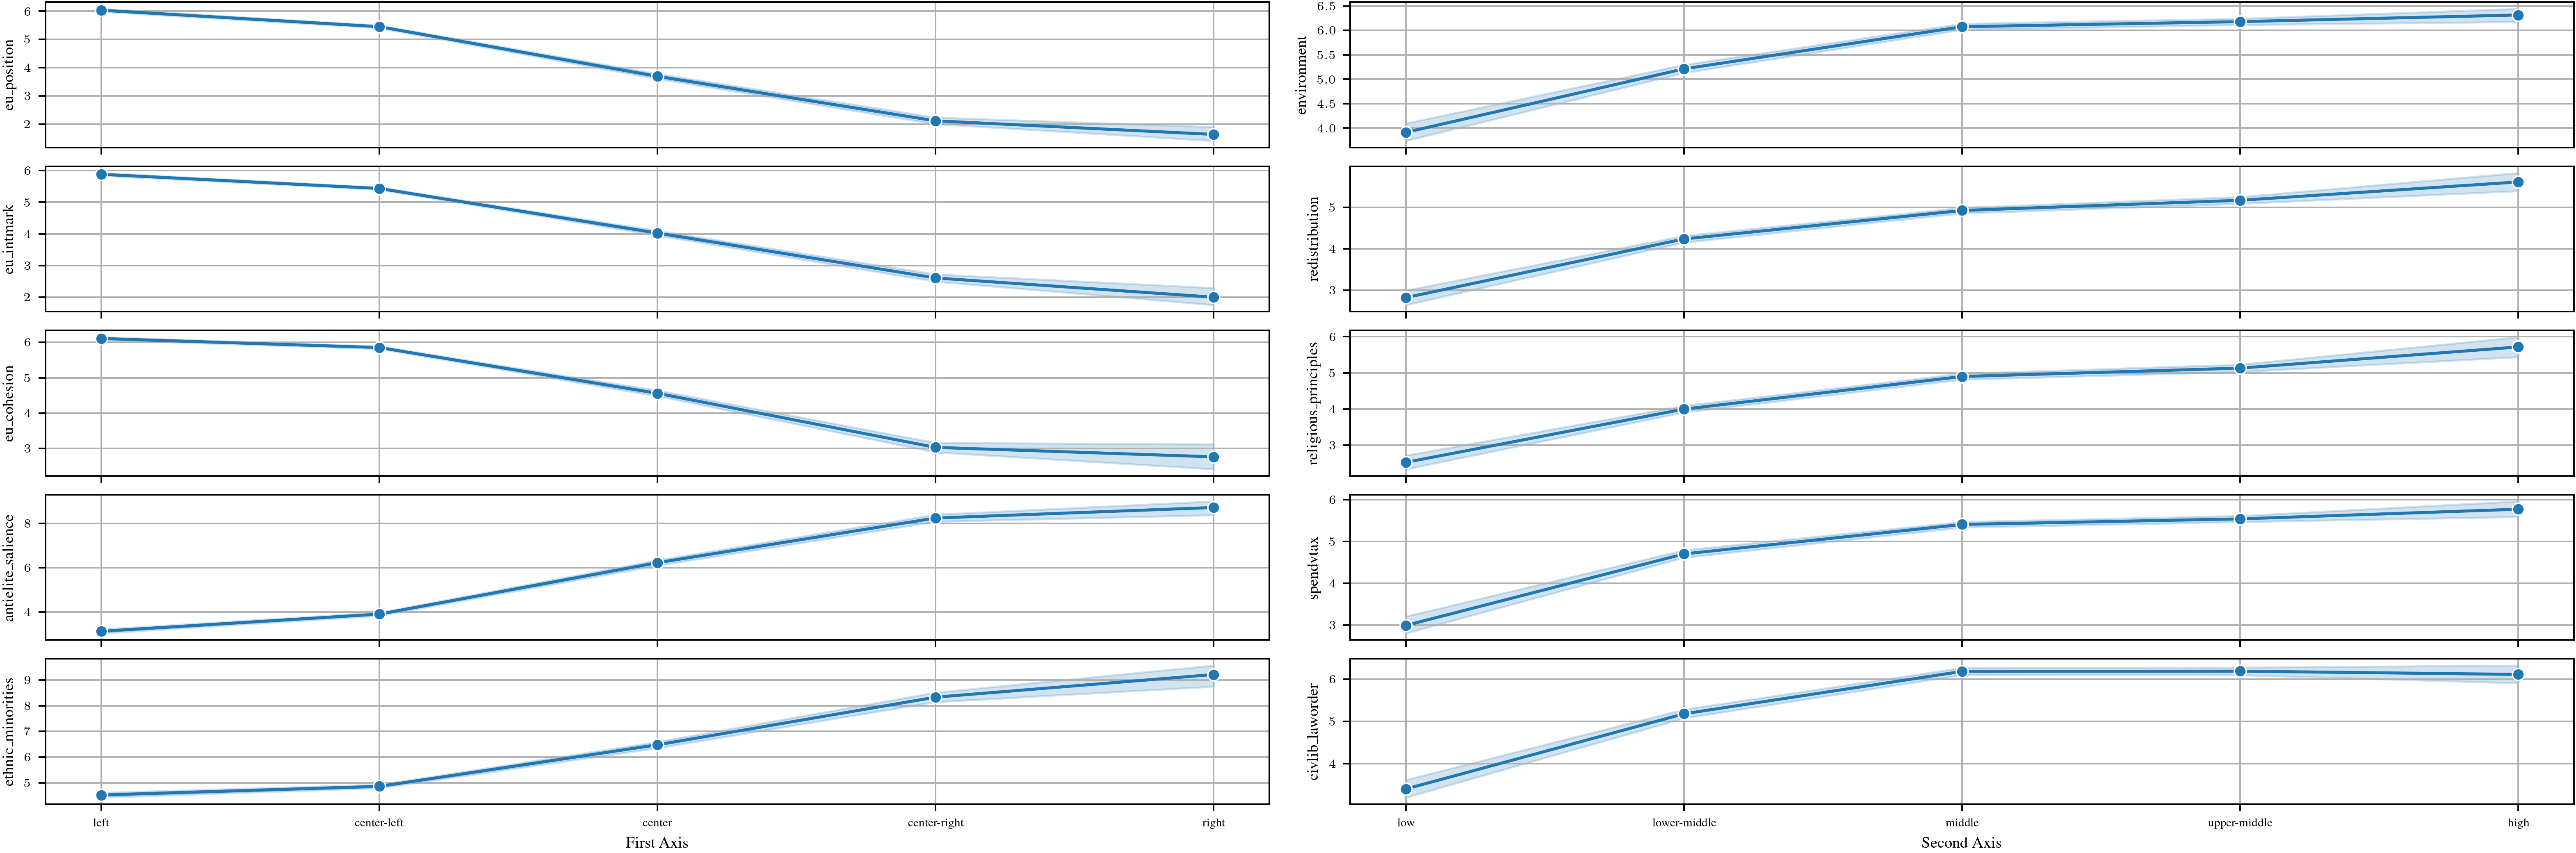

In [207]:
df[f"reduced_bin_y"] = pd.cut(df["reduced_y"], bins=5, labels=["low", "lower-middle", "middle", "upper-middle", "high"])
df[f"reduced_bin_x"] = pd.cut(df["reduced_x"], bins=5, labels=['left', 'center-left', 'center', 'center-right', 'right'])

fig, axs = plt.subplots(5, 2, figsize=(18, 6), sharex='col')

axs[-1][0].set_xlabel("First Axis")
axs[-1][1].set_xlabel("Second Axis")

for idx, (ches_metric_0, ches_metric_1) in enumerate(zip(axis_0_ches, axis_1_ches)):
    sns.lineplot(data=df, x='reduced_bin_x', y=ches_metric_0,  marker='o', ax=axs[idx][0])
    sns.lineplot(data=df, x='reduced_bin_y', y=ches_metric_1,  marker='o', ax=axs[idx][1])
    axs[idx][0].grid()
    axs[idx][1].grid()



In [96]:
df[f"environment_cat"]

0        (7.52, 9.308]
1        (5.732, 7.52]
2        (5.732, 7.52]
3        (5.732, 7.52]
4        (7.52, 9.308]
             ...      
9700    (2.156, 3.944]
9701    (3.944, 5.732]
9702               NaN
9703    (2.156, 3.944]
9704               NaN
Name: environment_cat, Length: 9705, dtype: category
Categories (5, interval[float64, right]): [(0.359, 2.156] < (2.156, 3.944] < (3.944, 5.732] < (5.732, 7.52] < (7.52, 9.308]]

<Axes: xlabel='year_x', ylabel='environment'>

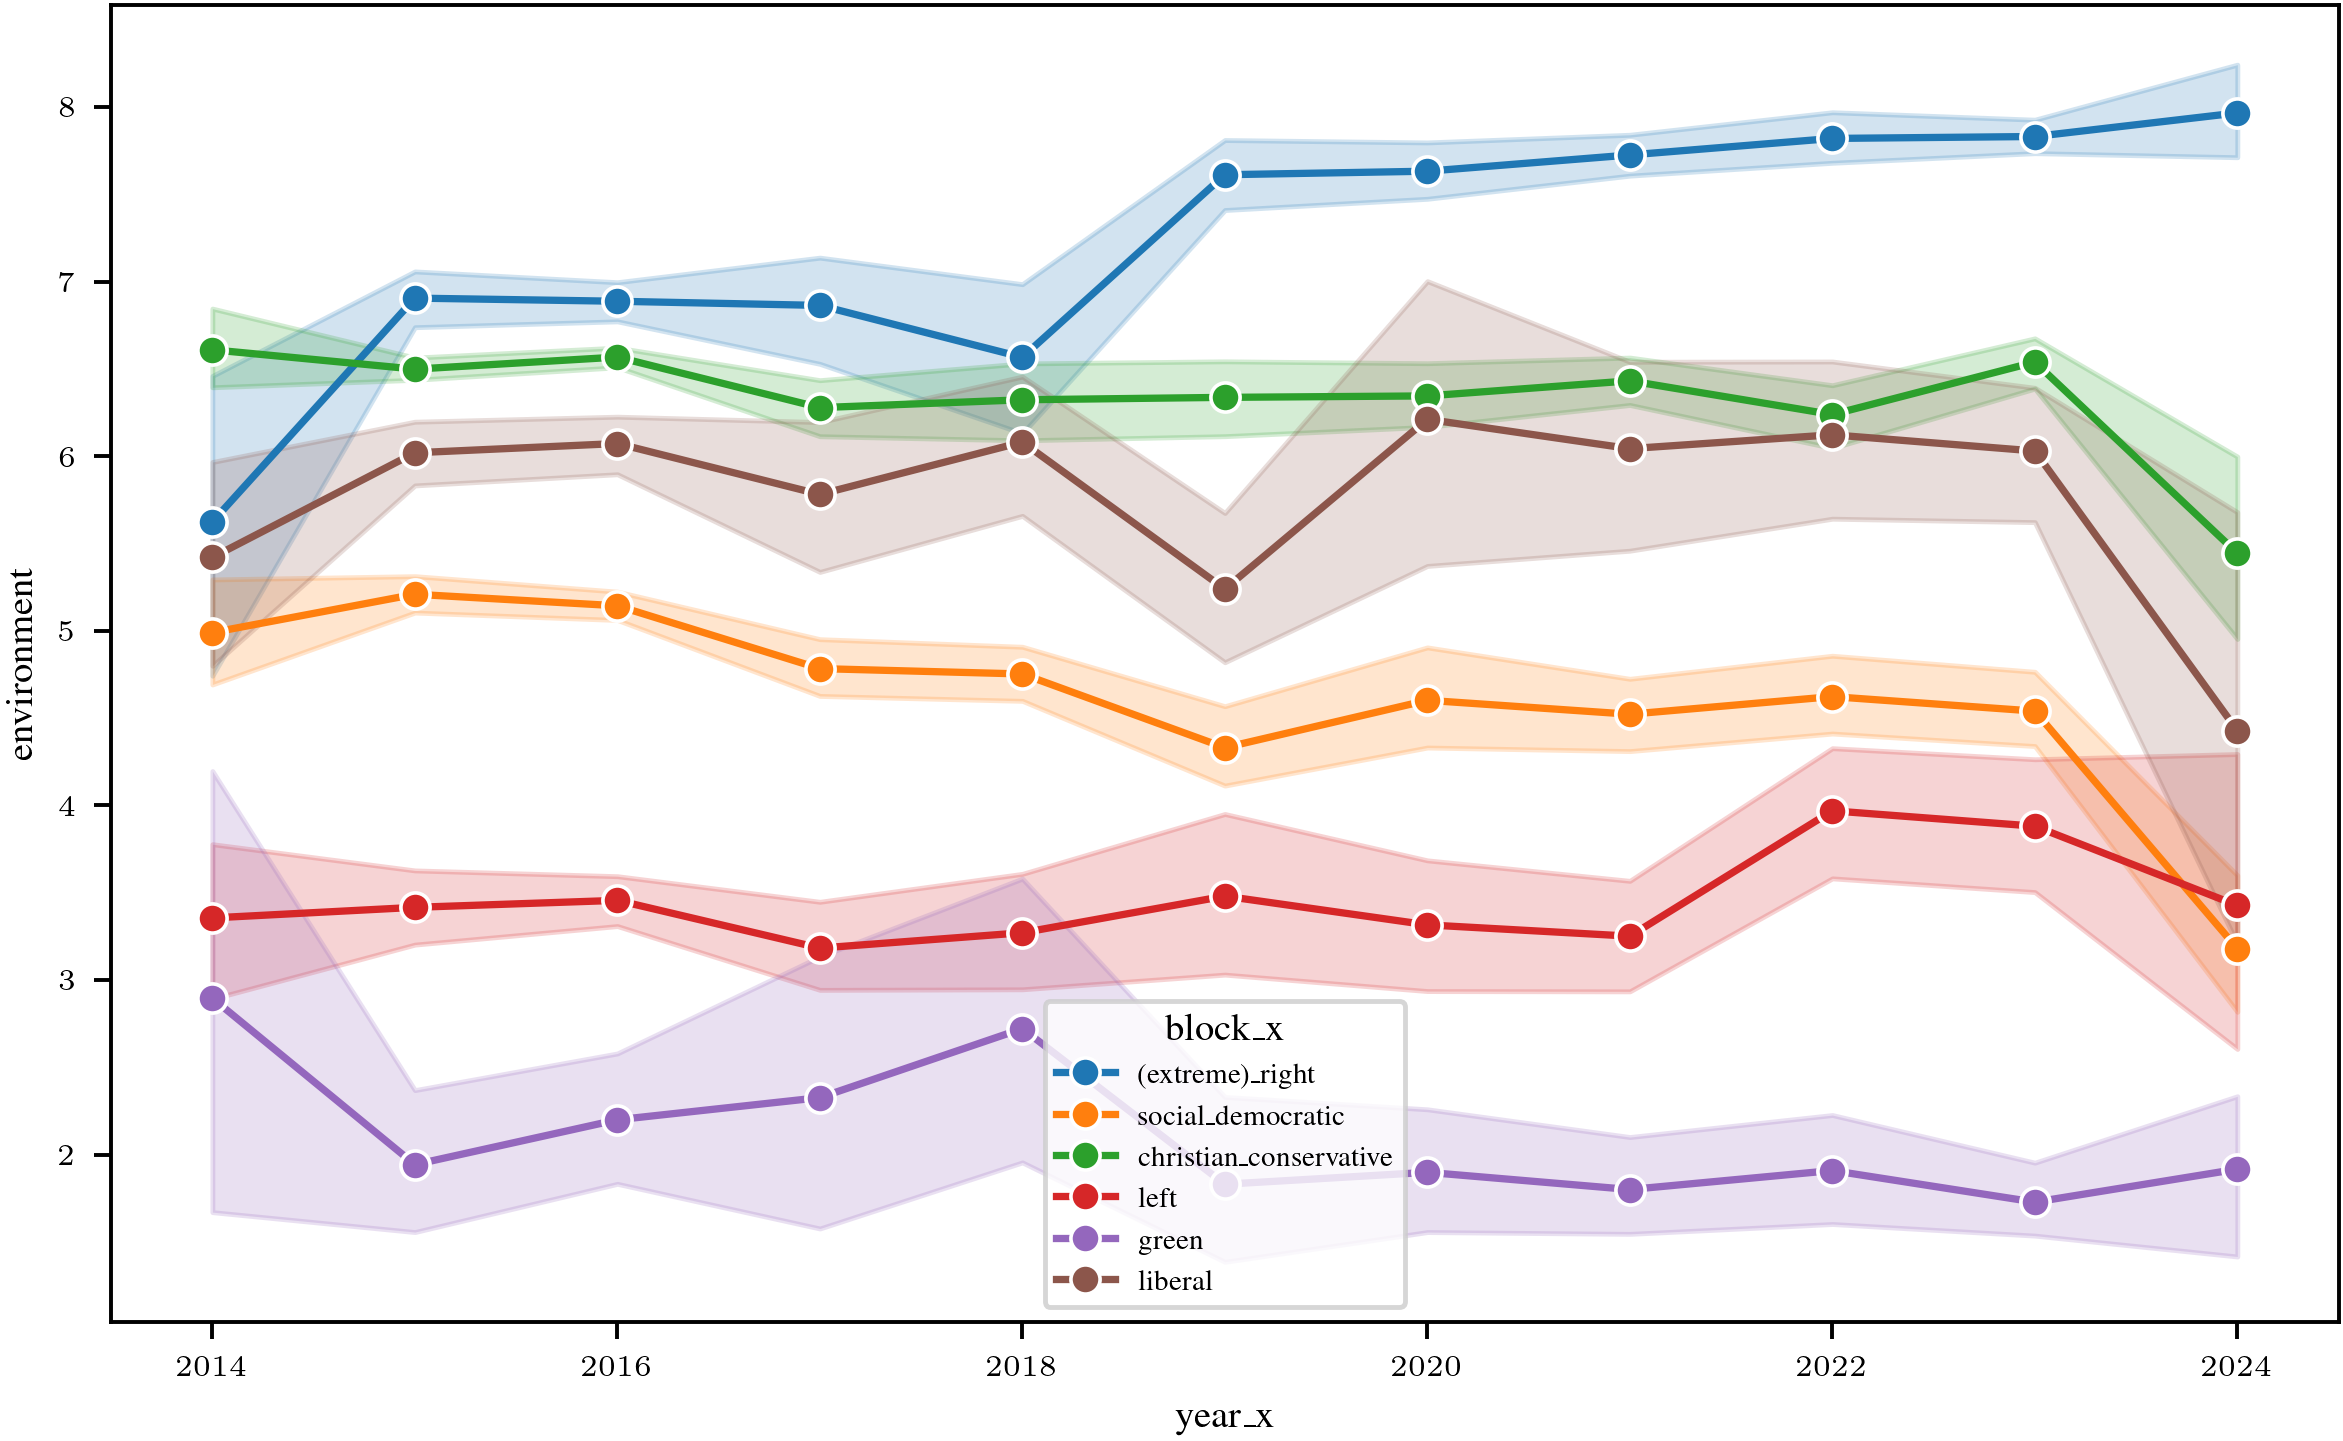

In [92]:
sns.lineplot(data=df, x='year_x', y="environment", hue="block_x", marker='o',)